Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [5]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [120]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14353,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14354,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14355,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14356,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


## Train Val Test spli
---

In [29]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=999)


In [41]:
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43622,35497,0.0,2013-02-13,Danida,1408,TCRS,30.792329,-3.302727,Kasongati Dispensary,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
48929,44547,0.0,2013-02-17,Jeica,1845,Jeica,35.454557,-4.443070,Martini,0,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
55267,68202,10.0,2013-03-13,Private Individual,1526,Dmdd,35.654975,-3.342370,Mali Ya Siri,0,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional
4857,73598,0.0,2011-03-11,Dhv,306,RWE,36.098232,-8.375779,Kwamhonja,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
54346,45020,0.0,2011-08-23,Ilo,1799,DWE,31.741836,-8.431201,Shule Ya Sekondari Mwazye,0,...,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15704,50250,0.0,2011-07-20,Kkkt,0,KKKT,32.807842,-8.997102,Nachimvitwa,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
30932,46343,50.0,2013-02-17,Lamp,1445,LAMP,36.481803,-5.561713,Mshineni,0,...,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,other,other,functional needs repair
51083,11479,100.0,2013-03-23,0,77,0,39.158845,-6.822600,Kwa Mkayu,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
4607,65191,0.0,2011-07-09,Roman Catholic Rulenge Diocese,0,DWE,31.398122,-2.570432,Kiriri,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


## Establishing baseline
---

In [31]:
train['status_group'].value_counts(normalize=True)

functional                 0.543097
non functional             0.384233
functional needs repair    0.072670
Name: status_group, dtype: float64

## Feature Selections
---

In [67]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [296]:
# Arrange data into X features matrix and y target vector 
X_train_pre = train[features]
y_train_pre = train[target]
X_val_pre = val[features]
y_val_pre = val[target]
X_test_pre = test[features]

In [376]:
drop_features = ['amount_tsh', 'gps_height','num_private','region_code','construction_year','public_meeting',
'scheme_management','extraction_type', 'extraction_type_group','management_group','payment_type', 'quality_group',
'source', 'source_type','waterpoint_type','region','recorded_by','permit'
]
X_train = X_train_pre.drop(drop_features,axis=1)
y_train = train[target]
X_val = X_val_pre.drop(drop_features,axis=1)
y_val = val[target]
X_test = X_test_pre.drop(drop_features,axis=1)

In [339]:
drop_features

['amount_tsh',
 'gps_height',
 'num_private',
 'region_code',
 'construction_year',
 'scheme_management',
 'extraction_type',
 'extraction_type_group',
 'management_group',
 'payment_type',
 'quality_group',
 'source',
 'source_type',
 'waterpoint_type',
 'region',
 'recorded_by',
 'permit',
 'district_code']

In [356]:
X_train = X_train_pre.drop(drop_features,axis=1)
y_train = train[target]
X_val = X_val_pre.drop(drop_features,axis=1)
y_val = val[target]
X_test = X_test_pre.drop(drop_features,axis=1)

In [341]:
X_train_pre

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
43622,0.0,1408,30.792329,-3.302727,0,16,1,500,2007,Lake Tanganyika,...,unknown,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
48929,0.0,1845,35.454557,-4.443070,0,21,2,213,2005,Internal,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
55267,10.0,1526,35.654975,-3.342370,0,24,30,800,1998,Internal,...,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe
4857,0.0,306,36.098232,-8.375779,0,5,3,560,1997,Rufiji,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
54346,0.0,1799,31.741836,-8.431201,0,15,2,359,1983,Lake Rukwa,...,never pay,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15704,0.0,0,32.807842,-8.997102,0,12,6,0,0,Lake Rukwa,...,on failure,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
30932,50.0,1445,36.481803,-5.561713,0,21,5,3355,1998,Wami / Ruvu,...,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,other,other
51083,100.0,77,39.158845,-6.822600,0,7,2,200,2000,Wami / Ruvu,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
4607,0.0,0,31.398122,-2.570432,0,18,4,0,0,Lake Victoria,...,annually,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [342]:
from pandas_profiling import ProfileReport
profile = ProfileReport(X_train, minimal=True).to_notebook_iframe()

profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


In [325]:
X_train

,longitude,latitude,district_code,population,basin,public_meeting,extraction_type_class,management,payment,water_quality,quantity,quantity_group,source_class,waterpoint_type_group
43622,30.792329,-3.302727,1,500,Lake Tanganyika,True,handpump,vwc,unknown,soft,enough,enough,groundwater,hand pump
48929,35.454557,-4.443070,2,213,Internal,True,gravity,vwc,never pay,soft,insufficient,insufficient,groundwater,communal standpipe
55267,35.654975,-3.342370,30,800,Internal,True,gravity,vwc,pay per bucket,soft,insufficient,insufficient,surface,communal standpipe
4857,36.098232,-8.375779,3,560,Rufiji,True,handpump,vwc,never pay,soft,insufficient,insufficient,groundwater,hand pump
54346,31.741836,-8.431201,2,359,Lake Rukwa,True,gravity,vwc,never pay,soft,seasonal,seasonal,surface,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15704,32.807842,-8.997102,6,0,Lake Rukwa,True,handpump,vwc,pay when scheme fails,soft,enough,enough,groundwater,hand pump
30932,36.481803,-5.561713,5,3355,Wami / Ruvu,True,submersible,vwc,pay per bucket,salty,insufficient,insufficient,groundwater,other
51083,39.158845,-6.822600,2,200,Wami / Ruvu,NaN,submersible,private operator,pay per bucket,soft,enough,enough,groundwater,communal standpipe
4607,31.398122,-2.570432,4,0,Lake Victoria,True,handpump,vwc,pay annually,soft,enough,enough,groundwater,hand pump


In [343]:
from pandas_profiling import ProfileReport
profile = ProfileReport(X_train, minimal=True).to_notebook_iframe()

profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


In [377]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude','population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    
    
    # return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

In [389]:

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=15, random_state=5312)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.799827366517325
Validation Accuracy 0.7453559099128719


In [374]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)

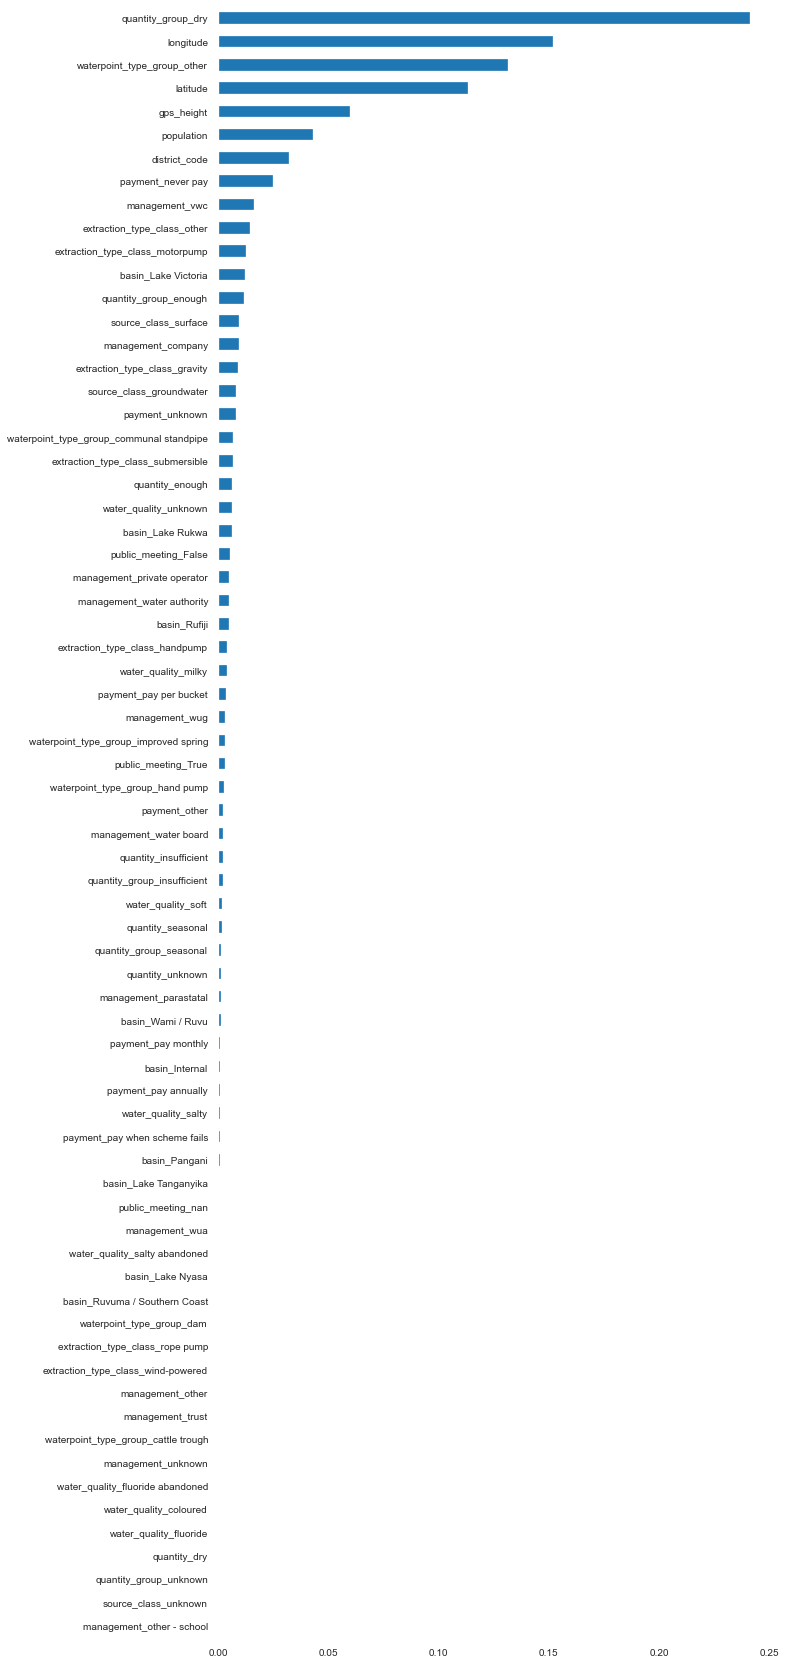

In [302]:
import matplotlib.pyplot as plt
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()
plt.show()

In [269]:
X_train.management.value_counts()

vwc                 16561
wug                  2679
water board          1219
wua                  1058
private operator      797
parastatal            726
other                 617
water authority       391
company               281
Name: management, dtype: int64

In [268]:
X_train.management[X_train.management == 'trust'] = 'other'